# 10 階層ベイズモデル -GLMMのベイズモデル化-

In [1]:
using Distributed
addprocs(3)
@everywhere begin
    using Pkg
    Pkg.activate(".")
    Pkg.instantiate()
end

 Activating 

      From worker 4:	 Activating environment at `~/Documents/kubo_analysis_julia/notebook/Project.toml`


environment at `~/Documents/kubo_analysis_julia/notebook/Project.toml`


      From worker 2:	 Activating environment at `~/Documents/kubo_analysis_julia/notebook/Project.toml`
      From worker 3:	 Activating environment at `~/Documents/kubo_analysis_julia/notebook/Project.toml`


In [2]:
using CSV
using DataFrames
using DataFramesMeta
using Distributions
using ForneyLab
using LaTeXStrings
@everywhere using Mamba
using Plots
using QuadGK
@everywhere using Random
using StatsBase
using StatsFuns
using StatsPlots
@everywhere Random.seed!(0)

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/matsueushi/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl


## 10.1 例題 : 個体差と生存種子数 (個体差あり)

In [3]:
df = CSV.read(joinpath("..", "data/section10a.csv"))
disallowmissing!(df)

,id,y
,Int64,Int64
1,1,0
2,2,2
3,3,7
4,4,8
5,5,1
6,6,7
7,7,8
8,8,8
9,9,1


青丸は観測データ, 白丸は生存確率0.504の二項分布. 二項分布では観測データのばらつきが説明できていない

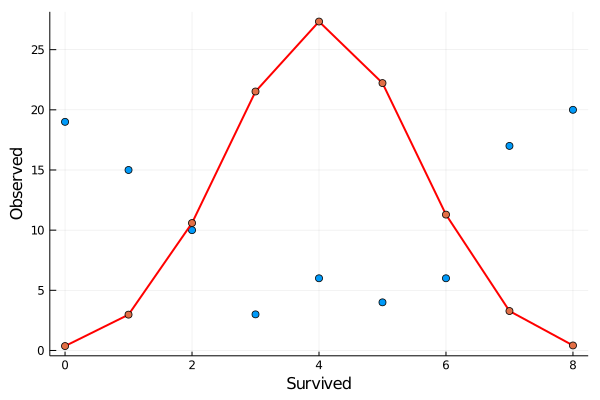

In [4]:
scatter(sort(unique(df.y)), counts(df.y), label="")
ys = pdf.(Binomial(8, 0.504), 0:8) .* 100
plot!(0:8, ys, linecolor=:red, linewidth=2,
    marker=4, label="",
    xlabel="Survived", ylabel="Observed")

## 10.3 階層ベイズモデルの推定・予測
### 10.3.1 階層ベイズモデルのMCMCサンプリング
### モデルの作成
$$\begin{align} y_i \sim \text{Binomial}(q_i, 8) \\
\text{logit}(q_i) = \beta + r_i \\
\beta \sim \text{Normal}(0, 100^2) \\
r_i \sim \text{Normal}(0, \tau^2) \\
\tau \sim \text{Uniform}(0, 10000) \end{align}$$

In [5]:
model = Model(
    y = Stochastic(1,
        (beta, r, N) ->
            UnivariateDistribution[
                (q = invlogit(beta + r[i]);
                Binomial(8, q)) for i in 1:N
            ],
        false
    ),

    beta = Stochastic(() -> Normal(0, 100)),

    r = Stochastic(1, s -> Normal(0, s), false),

    s = Stochastic(() -> Uniform(0, 10000)),
)

Object of type "Model"
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


### モデルの図示

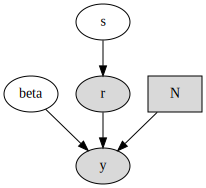

In [6]:
display("image/svg+xml", ForneyLab.dot2svg(graph2dot(model)))

### データの設定

In [7]:
data = let y=df.y[:]
    Dict{Symbol, Any}(
        :y => y,
        :N => length(y),
    )
end

Dict{Symbol,Any} with 2 entries:
  :N => 100
  :y => [0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0]

### 初期値の設定

In [8]:
inits = let y=df.y[:]
    [
        Dict{Symbol, Any}(
            :y => y,
            :beta => 0.0,
            :r => rand(Normal(0, 0.1), length(y)),
            :s => 1.0,
        ) for i in 1:3
    ]
end

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta => 0.0,:y => [0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s => 1.0,:r => [0.06791074260357777, 0.0828413482900036, -0.03530074003005963, -0.013485387193052173, 0.05866170746331098, 0.029733585084941616, 0.006494754854834233, -0.010901738508171745, -0.051421039083332204, 0.15743302021369893  …  0.044157293235560335, 0.1676893702842105, 0.02384811702037166, 0.23137925213196087, -0.00818509513815898, 0.13377955267452732, 0.12196310275075176, -0.1221868428597875, 0.025691447734545743, 0.07997110022690772])
 Dict(:beta => 0.0,:y => [0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s => 1.0,:r => [-0.06828316587443609, 0.015648268977079837, 0.014071362221573442, -0.012661169386986812, -0.11689770532667772, 0.06340673330099997, -0.09987096138584545, 0.10291211918802828, -0.11575125650724379, 0.05336042936683815  …  -0.15960024025105368, -0.09958703868973626, -0.06088355396146079, -0.17925102435122792, -0.11445

### MCMCサンプル方法の設定
NUTSを使うと遅くなってしまったので、AMWGを使用

In [9]:
scheme = [
    AMWG(:r, 1),
    Slice(:s, 1.0, Mamba.Univariate),
    Slice(:beta, 1.0, Mamba.Univariate),
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
[:r]

CodeInfo(
1 ─ %1 = π (Mamba.var"#199#201"{Symbol,Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), Core.Compiler.Const(Mamba.var"#199#201"{Symbol,Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Distributions.Univariate}}"
Sampling Block Nodes:
[:s]

CodeInfo(
1 ─ %1 = π (Mamba.var"#288#290"{Bool,Float64}(false, 1.0), Core.Compiler.Const(Mamba.var"#288#290"{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Distributions.Univariate}}"
Sampling Block Nodes:
[:beta]

CodeInfo

### MCMCサンプリング
サンプリングは21000回実施し, burn-inの数は1000, 10飛ばしの結果の記録を3チェイン行うので、
サンプルの数は(21000-1000)/10*3=6000個

In [10]:
setsamplers!(model, scheme)
sim = mcmc(model, data, inits, 21000, burnin=1000, thin=10, chains=3)

MCMC Simulation of 21000 Iterations x 3 Chains...

      From worker 2:	Chain 1:   0% [4:26:52 of 4:26:60 remaining]
      From worker 4:	Chain 2:   0% [4:23:15 of 4:23:23 remaining]
      From worker 3:	Chain 3:   0% [4:26:12 of 4:26:20 remaining]
      From worker 4:	Chain 2:  10% [0:03:58 of 0:04:24 remaining]
      From worker 2:	Chain 1:  10% [0:04:06 of 0:04:33 remaining]
      From worker 3:	Chain 3:  10% [0:04:05 of 0:04:32 remaining]
      From worker 4:	Chain 2:  20% [0:02:49 of 0:03:32 remaining]
      From worker 2:	Chain 1:  20% [0:02:55 of 0:03:38 remaining]
      From worker 3:	Chain 3:  20% [0:02:55 of 0:03:39 remaining]
      From worker 4:	Chain 2:  30% [0:02:14 of 0:03:12 remaining]
      From worker 2:	Chain 1:  30% [0:02:18 of 0:03:17 remaining]
      From worker 3:	Chain 3:  30% [0:02:18 of 0:03:18 remaining]
      From worker 4:	Chain 2:  40% [0:01:50 of 0:03:04 remaining]
      From worker 2:	Chain 1:  40% [0:01:58 of 0:03:16 remaining]
      From worker 3:	Chai

Object of type "ModelChains"

Iterations = 1010:21000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

[3.1990801406675016 -0.020322742609719946; 3.497878719915769 -0.14874310877833152; … ; 2.5165107482748073 0.55526783111907; 3.383644658588179 0.2540216787257331]

[3.146541701061607 0.2781685485889714; 2.671696699154572 0.4740493727454426; … ; 2.8632430632299912 0.4912069392232573; 2.526366087762697 0.4924352982829026]

[3.0205156286069306 0.3450904100063888; 2.621893183714474 0.3315117661157181; … ; 3.001911134086488 0.09816466052736617; 2.8902435564680253 0.2712293139065692]

### サンプリング結果を表示

In [11]:
describe(sim)

Iterations = 1010:21000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE        ESS   
   s 3.034657600 0.37081351 0.0047871819 0.0074216372 2000.0000
beta 0.021497145 0.35722822 0.0046117965 0.0102825139 1206.9601

Quantiles:
        2.5%       25.0%       50.0%       75.0%      97.5%  
   s  2.3933100  2.77724146 3.007355062 3.26020927 3.83733845
beta -0.6827564 -0.21481937 0.019123634 0.25415639 0.74354445



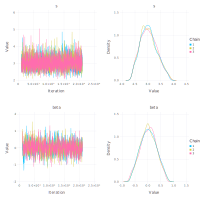

In [12]:
p = Mamba.plot(sim, legend=true)
Mamba.draw(p, nrow=2, ncol=2)

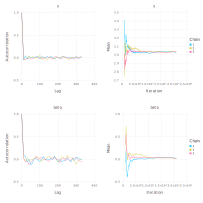

In [13]:
p = Mamba.plot(sim, [:autocor, :mean], legend=true)
Mamba.draw(p, nrow=2, ncol=2)

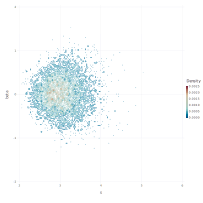

In [14]:
p = Mamba.plot(sim, :contour)
Mamba.draw(p, nrow=1, ncol=1)

### 10.3.2 階層ベイズモデルの事後分布推定と予測
$p(y \mid \beta, r)p(r \mid s)$を求める関数

In [15]:
function f_gaussian_binorm(alpha, x, size, fixed, sd)
    pdf(Binomial(size, logistic(fixed + alpha)), x) * pdf(Normal(0, sd), alpha)
end

f_gaussian_binorm (generic function with 1 method)

$p(y \mid \beta, s) = \int_{-\infty}^\infty p(y \mid \beta, r)p(r \mid s)dr$を求める関数.
実際は$\int_{-10s}^{10s} p(y \mid \beta, r)p(r \mid s)dr$を求めている

In [16]:
function d_gaussian_binorm(x, fixed, sd)
    quadgk(y -> f_gaussian_binorm(y, x, 8, fixed, sd), -sd * 10, sd * 10)[1]
end

d_gaussian_binorm (generic function with 1 method)

各パスに対し, $y = 0, \ldots, 8$ に対して $p(y \mid \beta, s)$ を評価する.

In [17]:
posterior = map((x, y) -> d_gaussian_binorm.(0:8, x, y), sim[:, [:beta], :].value[:], sim[:, [:s], :].value[:])

6000-element Array{Array{Float64,1},1}:
 [0.22942497778462778, 0.10445014285208594, 0.07456291806710194, 0.06368064994214544, 0.060696786277719864, 0.06354266368009617, 0.0742152400694242, 0.10359420185760851, 0.22583241946919028]
 [0.257654888880209, 0.1019905895863463, 0.07015230784046472, 0.05893106173704918, 0.055703385358536535, 0.058145599659606216, 0.06814756257143448, 0.09686960616328094, 0.23240499820307264]
 [0.23547240460192798, 0.09646745359097011, 0.06757373928402594, 0.057549736913246774, 0.05508426636421741, 0.058263166723615666, 0.06939747833192372, 0.10114735036434722, 0.2590444038257252]
 [0.20338905272568147, 0.09648112210181149, 0.07054047520648461, 0.06137600517737485, 0.0595176030503191, 0.06345881637582884, 0.07580235638637327, 0.10953257162881083, 0.25990199734731556]
 [0.17289155856993205, 0.0992563654057794, 0.0768314810729126, 0.06858029739727207, 0.0673090986353353, 0.07194643172900499, 0.0851503309695059, 0.11867314672040354, 0.2393612894998546]
 [0.1879583

各パスに対して、$P(X=y)=p(y \mid \beta, s)\ \text{for}\ y = 0, \ldots, 8$というCategorical distributionから100個体のサンプリングを行い,
$y$ごとに出現回数を数える. 横方向は各サンプリング, 縦方向は$y = 0, \ldots, 8$の出現回数に該当

In [18]:
population_samples = hcat(map(x -> fit(Histogram, rand(Distributions.Categorical(x), 100) .- 1, 0:9).weights, posterior)...)

9×6000 Array{Int64,2}:
 22  26  27  21  19  19  19  22  17  …  28  20  18  23  19  28  12  24  23
 14   7  10   7   8   9   9  11   6      7   9   7  12   6  15  13  13   5
  4   9   4   8  10   5   6   7   9      5   9   6   9  12   4   4   1   6
  4   2   6   9   5   9  12   6   5      7   8   6   4  12   6   6   7   8
  7   5   3   7   8   5  13   9   6      5   6   5   8   7   7  14  11   7
  7   5   7   6   3   9   9   5   7  …   6   9  10   3   3   7   6   3   4
 11   7   8   6   6   6   8   4   8      7   4   9   8  13   5  10  10  10
  6  12  10  11  12  20   9  12  12     10  12  13  12  11   9   6  12  15
 25  27  25  25  29  18  15  24  30     25  23  26  21  17  19  29  19  22

$y$毎に出現回数の2.5%, 50%, 97.5%点を計算

In [19]:
function quantile_sample(r)
    map(x -> quantile(population_samples[x, :], r), 1:9)
end
quantile_sample_0025 = quantile_sample(0.025)
quantile_sample_0975 = quantile_sample(0.975)
quantile_sample_median = quantile_sample(0.5)

9-element Array{Float64,1}:
 21.0
 10.0
  8.0
  7.0
  6.0
  7.0
  8.0
 10.0
 22.0

生存種子数の予測分布
各 $y$ における中央値, 及び95%区間の領域を表示する

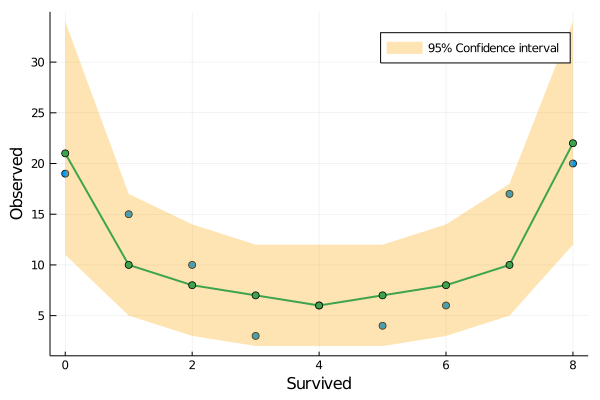

In [20]:
scatter(sort(unique(df.y)), counts(df.y), label="")
Plots.plot!(0:8, quantile_sample_0025, lw = 0,
    fillrange=quantile_sample_0975,
    fillalpha=0.3, fillcolor=:orange,
    label="95% Confidence interval")
Plots.plot!(0:8, quantile_sample_median, linewidth=2, marker=4, label="",
            xlabel="Survived", ylabel="Observed")

## 10.5 個体差 + 場所差の階層ベイズモデル

In [21]:
df2 = CSV.read(joinpath("..", "data/section10b.csv"))
disallowmissing!(df2)

,id,pot,f,y
,Int64,String,String,Int64
1,1,A,C,6
2,2,A,C,3
3,3,A,C,19
4,4,A,C,5
5,5,A,C,0
6,6,A,C,19
7,7,A,C,4
8,8,A,C,8
9,9,A,C,12


In [22]:
marker_dict = Dict(
    "A" => :circle,
    "B" => :ltriangle,
    "C" => :star5,
    "D" => :diamond,
    "E" => :dtriangle,
    "F" => :xcross,
    "G" => :star4,
    "H" => :utriangle,
    "I" => :rect,
    "J" => :rtriangle
)

Dict{String,Symbol} with 10 entries:
  "B" => :ltriangle
  "A" => :circle
  "I" => :rect
  "J" => :rtriangle
  "C" => :star5
  "D" => :diamond
  "G" => :star4
  "E" => :dtriangle
  "F" => :xcross
  "H" => :utriangle

### 個体ごとの表示
赤線は無処理、青線は堆肥処理した個体の平均

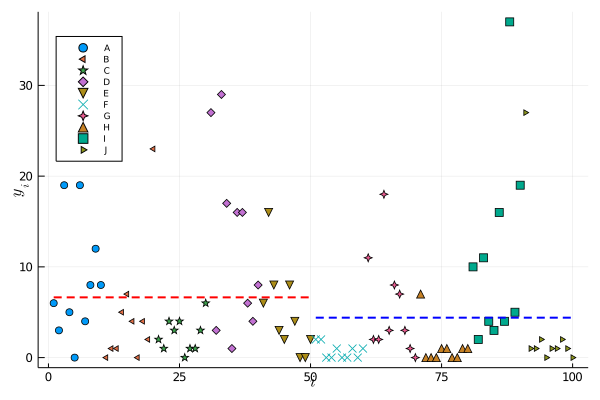

sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file


In [37]:
plt = Plots.plot()
for k in marker_dict |> keys |> collect |> sort
    @linq df_k = df2 |> where(:pot .== k)
    scatter!(df_k.id, df_k.y, label=k, markershape=marker_dict[k],
            legend=:topleft, legendfontsize=6, xlabel=L"i", ylabel=L"y_i")
end
plot!(1:50, fill(mean(df2[1:50, :].y), 50),
    linestyle=:dash, linewidth=2, linecolor=:red, label="")
plot!(51:100, fill(mean(df2[51:100, :].y), 50),
    linestyle=:dash, linewidth=2, linecolor=:blue, label="")
plt

### 植木鉢毎に箱ひげ図として図示

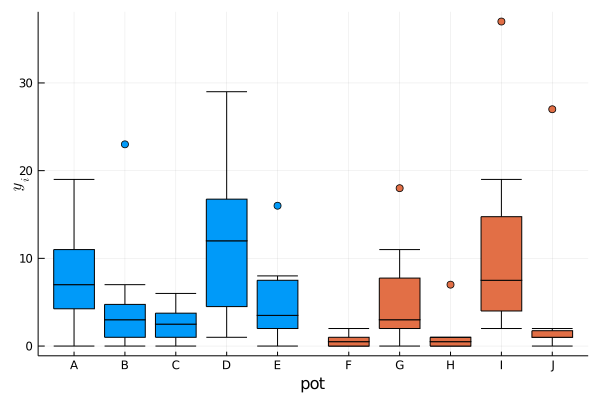

sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file
sh: latex: command not found
latex: failed to create a dvi file


In [24]:
boxplot(df2[1:50, :].pot, df2[1:50, :].y, label="")
boxplot!(df2[51:100, :].pot, df2[51:100, :].y, label="", xlabel="pot", ylabel=L"y_i")

### GLMM化したポアソン回帰
個体$i$の種子数$y_i$を平均$\lambda_i$のポアソン回帰

$$\begin{align} p(y_i \mid \lambda_i) = \frac{\lambda_i^{y_i}\exp(-\lambda_i)}{y_i!} \end{align}$$

で表現し, 平均種子数は切片$\beta_1$, 堆肥処理の有無を表す因子型の説明変数$f_i$の係数$\beta_2$, 個体$i$の効果$r_i$と植木鉢$j$の効果$t_{j(i)}$で

$$\begin{align} \log \lambda_i = \beta_1 + \beta_2 f_i + r_i + t_{j(i)} \end{align}$$

で表現.
$$\begin{align} y_i \sim \text{Poisson}(\lambda_i), \ i = 1, \ldots, 100 \\
\log \lambda_i = \beta_1 + \beta_2 f_i + r_i + t_{j(i)} \\
\beta_1, \beta_2 \sim \text{Normal}(0, 100) \\
r_i \sim \text{Normal}(0, s_r^2) \\
t_j \sim \text{Normal}(0, s_t^2), j = 1, \ldots, 10 \\
s_r, s_t \sim \text{Uniform}(0, 10000) \end{align}$$

In [25]:
model2 = Model(

    y = Stochastic(1,
        (beta1, beta2, f, r, t, pot, N_r) ->
            UnivariateDistribution[
                (lambda=exp(beta1 + beta2 * f[i] + r[i] + t[pot[i]]);
                Mamba.Poisson(lambda)) for i in 1:N_r
            ],
        false
    ),

    r = Stochastic(1, s_r -> Normal(0, s_r), false),

    t = Stochastic(1, s_t -> Normal(0, s_t), false),

    beta1 = Stochastic(() -> Normal(0, 100)),
    beta2 = Stochastic(() -> Normal(0, 100)),

    s_r = Stochastic(() -> Uniform(0, 10000)),
    s_t = Stochastic(() -> Uniform(0, 10000)),
)

Object of type "Model"
-------------------------------------------------------------------------------
beta2:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
s_r:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s_t:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
t:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
beta1:
A monitored node of type "ScalarS

### モデルの図示

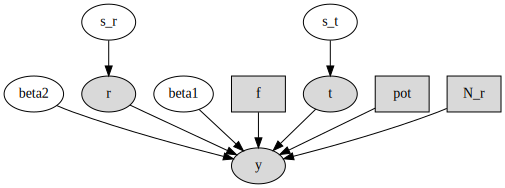

In [26]:
display("image/svg+xml", ForneyLab.dot2svg(graph2dot(model2)))

### 入力データの設定

In [27]:
pot_dict = Dict(string(y) => x for (x, y) in enumerate("ABCDEFGHIJ"))
f_dict = Dict("C" => 0, "T" => 1)
data2 = let y=df2.y[:], pot=df2.pot[:], f=df2.f[:]
    Dict{Symbol, Any}(
        :y => y,
        :N_r => length(y),
        :N_t => length(unique(pot)),
        :pot => [pot_dict[x] for x in pot],
        :f => [f_dict[x] for x in f],
    )
end

Dict{Symbol,Any} with 5 entries:
  :f   => [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  :N_t => 10
  :y   => [6, 3, 19, 5, 0, 19, 4, 8, 12, 8  …  27, 1, 1, 2, 0, 1, 1, 2, 1, 0]
  :N_r => 100
  :pot => [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  10, 10, 10, 10, 10, 10, 10, 10, 10,…

### 初期値の設定

In [28]:
inits2 = [
    Dict{Symbol, Any}(
        :y => data2[:y],
        :beta1 => 0.0,
        :beta2 => 0.0,
        :r => rand(Normal(0, 0.1), data2[:N_r]),
        :t => rand(Normal(0, 0.1), data2[:N_t]),
        :s_r => 1.0,
        :s_t => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta2 => 0.0,:s_r => 1.0,:y => [6, 3, 19, 5, 0, 19, 4, 8, 12, 8  …  27, 1, 1, 2, 0, 1, 1, 2, 1, 0],:s_t => 1.0,:beta1 => 0.0,:r => [-0.10872598069444028, 0.047506042782122, 0.11020194862263194, -0.05017110013906583, -0.1800815371378145, 0.04937244646073565, 0.13323697616788577, -0.011372837782258997, -0.06438663496137843, -0.026475564465848783  …  0.1967623558792171, 0.10272049465175509, 0.014237931995465875, 0.029763631526926345, -0.015595770464932058, 0.04023070618946642, -0.012997485147212638, 0.038974816455438994, 0.09421993101641891, -0.1632447017926982],:t => [0.049527619445245086, -0.10941258723747876, -0.10432990090474814, 0.2565021094296965, 0.19098250740137068, -0.004290207632157307, 0.11338016746443831, 0.1101702318924672, 0.059815705385368116, -0.1417368050208975])
 Dict(:beta2 => 0.0,:s_r => 1.0,:y => [6, 3, 19, 5, 0, 19, 4, 8, 12, 8  …  27, 1, 1, 2, 0, 1, 1, 2, 1, 0],:s_t => 1.0,:beta1 => 0.0,:r => [0.017928122189660358, 0.07682

In [29]:
scheme2 = [
    AMWG([:r], 0.1),
    AMWG([:t], 0.1),
    Slice([:s_r, :s_t], 0.1, Mamba.Univariate),
    Slice([:beta1, :beta2], 1.0, Mamba.Univariate)
]

4-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
[:r]

CodeInfo(
1 ─ %1 = π (Mamba.var"#199#201"{Symbol,Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), Core.Compiler.Const(Mamba.var"#199#201"{Symbol,Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
[:t]

CodeInfo(
1 ─ %1 = π (Mamba.var"#199#201"{Symbol,Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), Core.Compiler.Const(Mamba.var"#199#201"{Symbol,Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(

In [30]:
setsamplers!(model2, scheme2)
sim2 = mcmc(model2, data2, inits2, 22000, burnin=2000, thin=10, chains=3)

MCMC Simulation of 22000 Iterations x 3 Chains...

      From worker 3:	Chain 3:   0% [0:15:49 of 0:15:50 remaining]
      From worker 4:	Chain 1:   0% [0:20:09 of 0:20:09 remaining]
      From worker 2:	Chain 2:   0% [0:30:44 of 0:30:45 remaining]
      From worker 4:	Chain 1:  10% [0:03:26 of 0:03:49 remaining]
      From worker 2:	Chain 2:  10% [0:03:29 of 0:03:52 remaining]
      From worker 3:	Chain 3:  10% [0:03:32 of 0:03:55 remaining]
      From worker 4:	Chain 1:  20% [0:02:45 of 0:03:26 remaining]
      From worker 2:	Chain 2:  20% [0:02:48 of 0:03:30 remaining]
      From worker 3:	Chain 3:  20% [0:02:50 of 0:03:33 remaining]
      From worker 4:	Chain 1:  30% [0:02:26 of 0:03:29 remaining]
      From worker 2:	Chain 2:  30% [0:02:29 of 0:03:33 remaining]
      From worker 3:	Chain 3:  30% [0:02:31 of 0:03:36 remaining]
      From worker 4:	Chain 1:  40% [0:02:01 of 0:03:22 remaining]
      From worker 2:	Chain 2:  40% [0:02:03 of 0:03:25 remaining]
      From worker 3:	Chai

Object of type "ModelChains"

Iterations = 2010:22000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

[0.775496526825238 1.94592441986811 1.2772504829890077 -1.415717939851032; 0.8870409911285163 2.0544345729295714 1.2197160800768474 -1.509152782846378; … ; 1.2658320452347736 1.7734729167358583 1.0316637926116559 -1.113156943374272; 1.1689303378578366 1.7503966910613216 0.9646832282843251 -1.069616108163167]

[1.154086730593875 1.1226601729094736 0.9400627425241386 -1.8382691604356187; 1.2139681835283693 1.1116828146854254 0.983317995187739 -1.7906931089008729; … ; 0.9180059359868084 1.2078370920493737 1.182548552421992 -0.7735003878588067; 0.7640680730113568 1.0186639333104814 1.035436906363561 -0.8154556510971476]

[1.1127409365863286 0.9399816927349092 1.181813189160706 -0.6185279446348978; 1.1434490779364708 0.9253098524097743 1.01656164468387 -0.6076431216517197; … ; 2.042396922596686 3.0007962186991612 1.0764021005236966 -3.1837589110298503; 1.870803425761146 3.26

### 事後分布を確認する
β2の95%区間を見ると、堆肥処理の効果はなさそう

In [31]:
describe(sim2)

Iterations = 2010:22000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE        ESS   
  s_t  1.0973490 0.44899115 0.0057964508 0.044084884 103.728034
beta1  1.2584957 0.62813466 0.0081091836 0.062778078 100.112773
  s_r  1.0253322 0.11666467 0.0015061344 0.004606777 641.334092
beta2 -0.7390303 0.83327142 0.0107574878 0.080241464 107.838861

Quantiles:
         2.5%       25.0%      50.0%       75.0%     97.5%  
  s_t  0.5208161  0.7947396  0.99786706  1.2941489 2.2965467
beta1 -0.1702917  0.8933134  1.30623246  1.6384940 2.5287776
  s_r  0.8174254  0.9443848  1.01547404  1.0988971 1.2772550
beta2 -2.4363883 -1.2371125 -0.76338137 -0.2352228 0.9790624



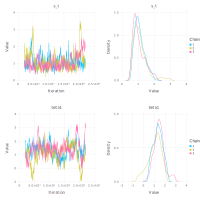

In [32]:
p = Mamba.plot(sim2, legend=true)
Mamba.draw(p[:, 1:2], nrow=2, ncol=2)

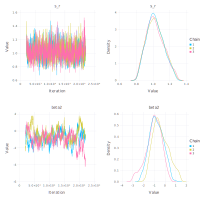

In [33]:
Mamba.draw(p[:, 3:4], nrow=2, ncol=2)

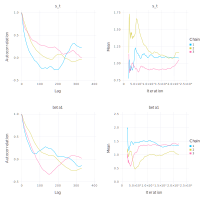

In [34]:
p = Mamba.plot(sim2, [:autocor, :mean], legend=true)
Mamba.draw(p[:, 1:2], nrow=2, ncol=2)

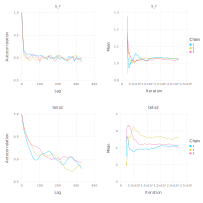

In [35]:
Mamba.draw(p[:, 3:4], nrow=2, ncol=2)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*